In [4]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [28]:
import os

def read_data(experiment_name):
    return pd.read_json(os.path.join('results', experiment_name, 'progress.json'), lines=True)

def analyze(experiment_name):
    df = read_data(experiment_name)
    df.plot(x='time elapsed', y='mean episode reward')
    df.plot(x='steps', y='mean episode reward')
    df.plot(x='episodes', y='mean episode reward')
    
def analyze_experiments(experiments, x_label, y_label):
    data = {}
    for experiment in experiments:
        data[experiment] = read_data(experiment)
        
    ax = None
    for name, df in data.items():
        ax = df.plot(x=x_label, y=y_label, ax=ax, label=name)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [29]:
experiments = [
    'multi_deepq_4',
    'multi_deepq_8',
    'multi_deepq_16',
    'multi_deepq_32',
    'multi_deepq_64',
    'multi_deepq_128',
    'multi_deepq_256',
]

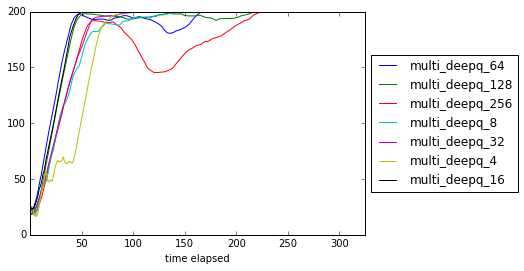

In [30]:
analyze_experiments(experiments, 'time elapsed', 'mean episode reward')

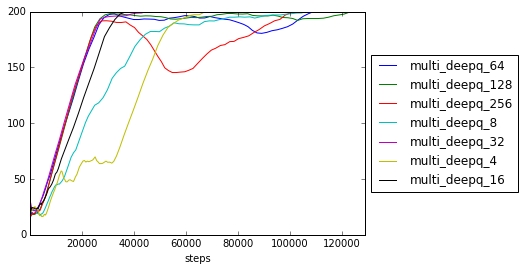

In [31]:
analyze_experiments(experiments, 'steps', 'mean episode reward')

In [57]:
doom_exp = [
    'multi_deepq_doom_training_ppaquette/DoomBasic-v0_batch_size_32_worker_count_1_tf_thread_count_8',
    'multi_deepq_doom_training_ppaquette/DoomBasic-v0_batch_size_128_worker_count_1_tf_thread_count_8',
#     'acktr_doom',
#     'a2c_doom',
]

In [58]:
# df = pd.read_json(os.path.join('results', 'a2c_doom', '0.monitor.json'), lines=True)[1:]

In [59]:
# df.plot(x='t', y='r')

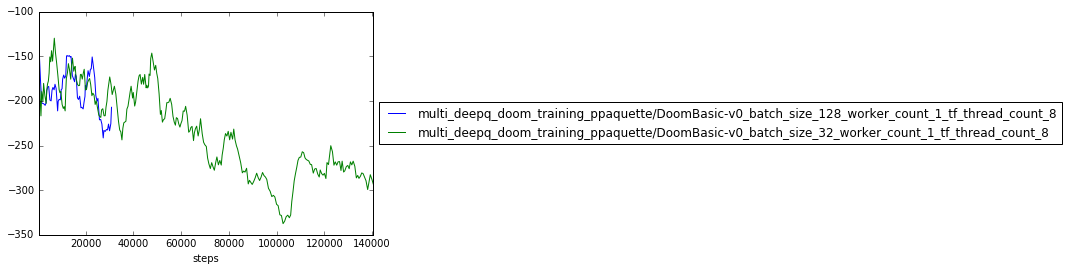

In [64]:
analyze_experiments(doom_exp, 'steps', 'mean episode reward')

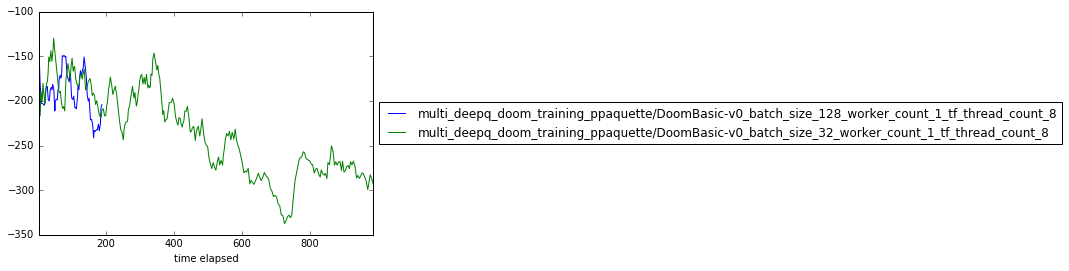

In [65]:
analyze_experiments(doom_exp, 'time elapsed', 'mean episode reward')